In [20]:
from pathlib import Path
import pandas as pd
import os

base_dir = Path(os.getcwd()).parent

df = pd.read_csv(base_dir / 'data' / 'all_articles_with_sentiment.csv')

In [21]:
import torch

df['date'] = pd.to_datetime(df['date'], format='%y-%m-%d', errors='coerce')
df = df.dropna(subset=['date']) # remove invalid dates

df['score'] = df['score'].apply(
    lambda x: eval(x.replace("device='cuda:0'", ""), {"tensor": torch.tensor}) if isinstance(x, str) else x
)
df['score'] = df['score'].apply(lambda x: x.cpu() if isinstance(x, torch.Tensor) else x)

In [22]:
df = df[df['paper'] != 'dn']
df = df[df['paper'] != 'da']
df = df[df['paper'] != 'db']

In [23]:
start_date = pd.Timestamp('2006-01-01')
end_date = pd.Timestamp('2010-01-01')

df = df[(df['date'] >= start_date) & (df['date'] <= end_date)] # filter out dates

In [24]:
weight_factor = 7.5
df['score'] = df['score'].apply(lambda x: x * weight_factor if x < 0 else x)

In [25]:
avg_sentiment = df.groupby(['date', 'paper'])['score'].mean().reset_index() # average sentiment score for each date
avg_sentiment = avg_sentiment.sort_values(by=['date', 'paper']) # sort by date

In [26]:
avg_sentiment['score'] = pd.to_numeric(avg_sentiment['score'], errors='coerce')

In [27]:
avg_sentiment['cumulative'] = avg_sentiment.groupby('paper')['score'].cumsum()

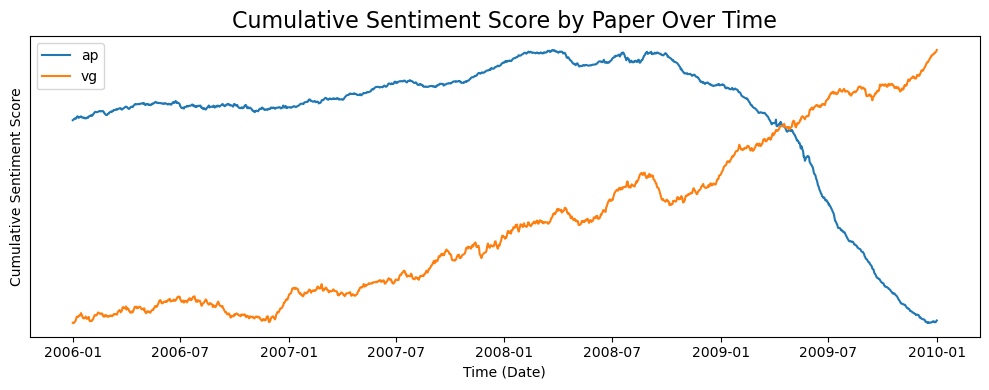

In [28]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

avg_sentiment['scaled_cum'] = avg_sentiment.groupby('paper')['cumulative'].transform(
    lambda x: scaler.fit_transform(x.values.reshape(-1, 1)).flatten()
)

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))

for paper in avg_sentiment['paper'].unique():
    paper_data = avg_sentiment[avg_sentiment['paper'] == paper]
    plt.plot(paper_data['date'], paper_data['scaled_cum'], label=paper)

plt.yticks([])

plt.xlabel('Time (Date)')
plt.ylabel('Cumulative Sentiment Score')
plt.title('Cumulative Sentiment Score by Paper Over Time', fontsize=16)
plt.legend()
plt.tight_layout()
plt.savefig('SentimentAcrossPapers.png')
plt.show()
